In [1]:
%load_ext autoreload
%autoreload 2

# Comapare all the models on test set

In [2]:
from train_multiview_network import TrainMultiInputModel
from multi_view_classification_network import MultiInputModel
from config import get_config
import torch
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ptflops as ptf
import os
#from fvcore.nn import FlopCountAnalysis, flop_count
from copy import copy, deepcopy
import json


In [3]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def modified_resnet(model):
    model.fc = Identity()
    return model

def modified_densenet(model):
    model.classifier = Identity()
    return model 

In [4]:
models = [{'model':torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1'),
                                      'avgpool':torch.nn.AdaptiveAvgPool2d(1),
                                      'last_layer_size':2048,
                                      'model_name' : 'EfficientNet',
                                       'features' : None
          },
          {'model':torchvision.models.densenet121(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':1024,
                                  'model_name' : 'DenseNet121',
                                   'features' : modified_densenet(torchvision.models.densenet121(weights='IMAGENET1K_V1')),
            },
          {'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
          {'model':torchvision.models.vgg16(weights='IMAGENET1K_V1'),
                                  'avgpool':torch.nn.AdaptiveAvgPool2d((1,1)),
                                  'last_layer_size':512,
                                  'model_name' : 'VGG',
                                   'features' : None
            },
          
          {'model':torchvision.models.resnet152(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet152',
                                   'features' : modified_resnet(torchvision.models.resnet152(weights='IMAGENET1K_V1'))
            }
          
]

In [5]:
_, data_config = get_config()

In [6]:
model_config = {'learning_rate' : 0.001,
                      "epochs" : 30,
                      "pretrained":True,
                      "fine_tune":False,
                        "model_recto":{'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
                        "model_verso":{'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
                     }

In [7]:
trainer = TrainMultiInputModel(model_config,data_config)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


In [34]:
sum( p.numel() for p in trainer.model.parameters())

58172487

In [22]:
all_outputs["ResNet50_ResNet50"]['nb_parameters']

23536711

In [45]:
y_train = []
for i, recto in tqdm(enumerate(trainer.trainRectoloader), total=len(trainer.trainVersoloader)):
        _, labels = recto
        y_train.append(labels.tolist())
y_train = [item for sublist in y_train for item in sublist]
from collections import Counter
print(Counter(y_train))
print(len(y_train))
print(list(map(lambda x : round(x/len(y_train)*100,2),Counter(y_train).values())))

100%|██████████| 73/73 [00:25<00:00,  2.83it/s]

Counter({0: 395, 3: 357, 6: 356, 5: 315, 4: 309, 2: 309, 1: 266})
2307
[13.39, 13.65, 15.43, 13.39, 17.12, 15.47, 11.53]


In [44]:
y_valid = []
for i, recto in tqdm(enumerate(trainer.validRectoloader), total=len(trainer.validRectoloader)):
        _, labels = recto
        y_valid.append(labels.tolist())
y_valid = [item for sublist in y_valid for item in sublist]
print(Counter(y_valid))
print(len(y_valid))
print(list(map(lambda x : round(x/len(y_valid)*100,2),Counter(y_valid).values())))

100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

Counter({0: 99, 3: 90, 6: 89, 5: 79, 4: 77, 2: 77, 1: 66})
577
[13.69, 17.16, 13.34, 15.6, 11.44, 13.34, 15.42]


In [8]:
def input_constructor(input_res):
            recto = torch.ones(()).new_empty((1, *input_res),
                                                     device=trainer.device) 
            verso = torch.ones(()).new_empty((1, *input_res),
                                                     device=trainer.device)
            return {"two_views": [recto,verso]}

In [9]:
y_obs = []
for i, recto in tqdm(enumerate(trainer.testRectoloader), total=len(trainer.testVersoloader)):
        _, labels = recto
        y_obs.append(labels.tolist())
y_obs = [item for sublist in y_obs for item in sublist]
#print(Counter(y_obs))
print(len(y_obs))
#print(list(map(lambda x : round(x/len(y_obs)*100,1),Counter(y_obs).values())))

100%|██████████| 91/91 [00:30<00:00,  2.94it/s]

2885


In [10]:
try :
    with open("outputs/test_results_full_evalmode.json") as f:
        all_outputs = json.load(f)
except :
    all_outputs = {}

In [62]:
all_outputs.keys()

dict_keys(['EfficientNet_EfficientNet', 'EfficientNet_DenseNet121', 'EfficientNet_ResNet50', 'EfficientNet_VGG', 'EfficientNet_ResNet152', 'DenseNet121_EfficientNet', 'DenseNet121_DenseNet121', 'DenseNet121_ResNet50', 'DenseNet121_VGG', 'DenseNet121_ResNet152', 'ResNet50_EfficientNet', 'ResNet50_DenseNet121', 'ResNet50_ResNet50', 'ResNet50_VGG', 'ResNet50_ResNet152', 'VGG_EfficientNet', 'VGG_DenseNet121', 'VGG_ResNet50', 'VGG_VGG', 'VGG_ResNet152', 'ResNet152_EfficientNet', 'ResNet152_DenseNet121', 'ResNet152_ResNet50', 'ResNet152_VGG', 'ResNet152_ResNet152'])

In [13]:
step = 0
for modelR in models :
   for modelV in models :
      step += 1 
      print(f"STEP {step}/25")
      temp = {}
      model_config = {'learning_rate' : 0.001,
                     "epochs" : 30,
                     "pretrained":True,
                     "fine_tune":False,
                     "model_recto":modelR,
                     "model_verso":modelV,
                  }
      torch.cuda.empty_cache()
      trainer = TrainMultiInputModel(model_config,data_config)
      model_recto = modelR
      model_verso =   modelV
      model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=False, num_classes=7)
      #checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_{modelR["model_name"]}_model_verso_{modelV["model_name"]}_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
      #model.load_state_dict(checkpoint['model_state_dict'])
      #model = model.to(trainer.device)
      print(sum(
         p.numel() for p in model.parameters()))  

STEP 1/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
28369463
STEP 2/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
35316151
STEP 3/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
51877495
STEP 4/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
43073399
STEP 5/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
86513271
STEP 6/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
35316151
STEP 7/25
[INFO]: Loading pre-trained weights


In [29]:
"EfficientNet_EfficientNet" in all_outputs.keys()

True

In [11]:
import os
#all_models_weight = [f for f in os.listdir('/home/onyxia/work/pfe-deep-learning-maladies-plantes/multi_vue_pytorch/outputs') if f.endswith(".pth")]
#all_outputs = {}
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
step = 0
for modelR in models :
    for modelV in models :
        step += 1 
        if f"{modelR['model_name']}_{modelV['model_name']}" not in all_outputs.keys():
            print(f"{modelR['model_name']}_{modelV['model_name']}")
            print(f"STEP {step}/25")
            temp = {}
            model_config = {'learning_rate' : 0.001,
                        "epochs" : 30,
                        "pretrained":True,
                        "fine_tune":False,
                        "model_recto":deepcopy(modelR),
                        "model_verso":deepcopy(modelV),
                     }
            torch.cuda.empty_cache()
            trainer = TrainMultiInputModel(model_config,data_config)
            model_recto = modelR
            model_verso =   modelV           
            model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=False, num_classes=7)
            try :
             checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_{modelR["model_name"]}_model_verso_{modelV["model_name"]}_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
             #model.load_state_dict({cle: checkpoint['model_state_dict'][cle] for cle in checkpoint['model_state_dict'].keys() if not cle.startswith("modelRecto.") and not cle.startswith("modelVerso.")})
             model.load_state_dict(checkpoint['model_state_dict'])
             model = model.to(trainer.device)
             trainer.model = model
             preds, max_probs, all_probs = trainer.predict(trainer.testRectoloader,trainer.testVersoloader)
             macs,_ = ptf.get_model_complexity_info(trainer.model, (3, 224, 224), as_strings=False,
                                                       print_per_layer_stat=False, verbose=False,input_constructor = input_constructor)
             all_outputs[model.name] = {
             "pred" : le.inverse_transform(preds).tolist(),
             "max_probs" : max_probs,
             "all_probs" : all_probs,
             "accuracy" : accuracy_score(y_obs,preds),
             "balanced_accuracy" : balanced_accuracy_score(y_obs,preds),
             "precision_micro" : precision_score(y_obs,preds,average="micro"),
             "recall_micro" : recall_score(y_obs,preds,average="micro"),
             "precision_micro" : precision_score(y_obs,preds,average="micro"),
             "recall_micro" : recall_score(y_obs,preds,average="micro"),
             "roc_auc_micro" : roc_auc_score(y_obs,all_probs,average="micro",multi_class='ovr'),
             "f1_score_micro" : f1_score(y_obs,preds,average="micro"),
             "precision_weighted" : precision_score(y_obs,preds,average="weighted"),
             "recall_weighted" : recall_score(y_obs,preds,average="weighted"),
             "precision_weighted" : precision_score(y_obs,preds,average="weighted"),
             "recall_weighted" : recall_score(y_obs,preds,average="weighted"),
             "roc_auc_weighted" : roc_auc_score(y_obs,all_probs,average="weighted",multi_class='ovo'),
             "f1_score_weighted" : f1_score(y_obs,preds,average="weighted"),
             "nb_trainable_parameters" : sum(
                p.numel() for p in model.parameters() if p.requires_grad),
             "nb_parameters" : sum(
                p.numel() for p in model.parameters()),
             "macs" : macs
             }
            except:
                pass

EfficientNet_VGG
STEP 4/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
EfficientNet_ResNet152
STEP 5/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet50_EfficientNet
STEP 11/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet50_VGG
STEP 14/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet50_ResNet152
STEP 15/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
VGG_EfficientNet
STEP 16/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
VGG_DenseNet121
STEP 17/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
VGG_ResNet50
STEP 18/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
VGG_VGG
STEP 19/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
VGG_ResNet152
STEP 20/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet152_EfficientNet
STEP 21/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet152_DenseNet121
STEP 22/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet152_ResNet50
STEP 23/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet152_VGG
STEP 24/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.
ResNet152_ResNet152
STEP 25/25
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.


In [12]:
with open("outputs/test_results_full_evalmode.json","w",encoding='utf-8') as f:
    json.dump(all_outputs, f, ensure_ascii=False, indent=4)

In [13]:
with open("outputs/test_results_full_evalmode.json") as f:
    all_outputs = json.load(f)

In [14]:
all_outputs = {k:v for k,v in all_outputs.items() if "EfficientNetV2" not in k}

In [16]:
all_outputs.keys()

dict_keys(['EfficientNet_EfficientNet', 'EfficientNet_DenseNet121', 'EfficientNet_ResNet50', 'DenseNet121_EfficientNet', 'DenseNet121_DenseNet121', 'DenseNet121_ResNet50', 'DenseNet121_VGG', 'DenseNet121_ResNet152', 'ResNet50_DenseNet121', 'ResNet50_ResNet50'])

In [51]:
np.quantile([all_outputs[model]['nb_parameters'] for model in all_outputs.keys()],q=[0,0.25,0.5,0.75,1])

array([1.39220550e+07, 3.53161510e+07, 4.70447430e+07, 7.28764230e+07,
       1.16316295e+08])

### Plot macs/accuracy/parameters

20M<=50M
['<20M', '20M<=50M', '50M<=80M', '>80M']


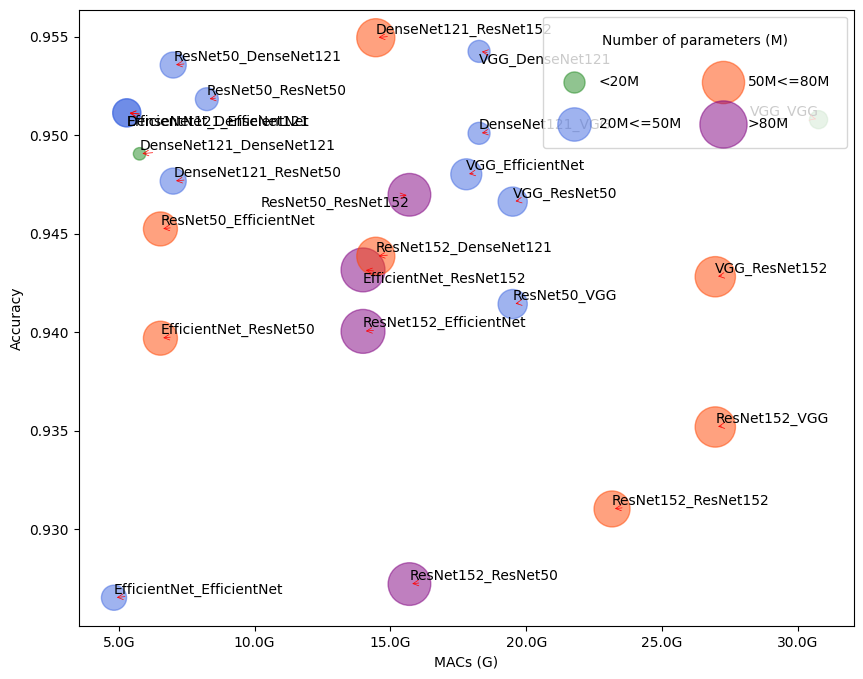

In [13]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
# Préparation des données pour le graphique
names = []
macs = []
accuracy = []
params = []
max_params = max(values['nb_parameters'] for values in all_outputs.values())
for name, values in all_outputs.items():
    names.append(name)
    macs.append(values['macs'] / 1e9)  # Convert MACs to GigaMACs
    accuracy.append(values['accuracy'])
    params.append((values['nb_parameters'] / max_params) * 1000)

# Define color intervals and corresponding colors
sizes = [20*10**6, 50*10**6, 80*10**6]
colors = ['forestgreen', 'royalblue', 'orangered', 'purple']

# Create a function to map values to colors based on predefined intervals
def map_value_to_color(value, intervals, colors):
    for i, interval in enumerate(intervals):
        if value <= (interval/max_params)*1000:
            return colors[i]
    return colors[-1]

# Map each value in params to a color based on the predefined intervals
point_colors = [map_value_to_color(param, sizes, colors) for param in params]
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(x=macs, y=accuracy, s=params, alpha=0.5, c=point_colors)

plt.xlabel('MACs (G)')
plt.ylabel('Accuracy')

# Format x-axis tick labels as scientific notation with "G" unit
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.offsetText.set_visible(False)
ax.xaxis.set_major_formatter('{x:.1f}G')
labels = []
for i in range(len(sizes)):
    if i == 0:
        labels.append(f"<{sizes[i]/(10**6):.0f}M")
    elif i == len(sizes)-1:
        labels.append(f'{sizes[i-1]/(10**6):.0f}M<={sizes[i]/(10**6):.0f}M')
        labels.append(f'>{sizes[i]/(10**6):.0f}M')
    else :
        print(f'{sizes[i-1]/(10**6):.0f}M<={sizes[i]/(10**6):.0f}M')
        labels.append(f'{sizes[i-1]/(10**6):.0f}M<={sizes[i]/(10**6):.0f}M') # Define labels for the legend
print(labels)
handles = [plt.scatter([], [], s=(s/max_params)*1000, alpha=0.5,c=map_value_to_color((s/max_params)*1000, sizes, colors)) for s in sizes+[100*10**6]]  # Create dummy scatter plots for the legend
legend = plt.legend(handles, labels, title='Number of parameters (M)', scatterpoints=1, labelspacing=2, loc='upper right',ncol=2,borderpad=1.2)
plt.setp(legend.get_title(), fontsize='medium')
# Ajout des annotations
texts = []
for x, y, s in zip(macs, accuracy, names):
    texts.append(plt.text(x, y, s))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.show()
fig.savefig("outputs/model_performance_plot_acc_mac.pdf",format="pdf")

### Table with results

In [14]:
dict_res = {key1: { key2 : round(all_outputs[key1][key2],3) for key2 in ["accuracy","balanced_accuracy","precision_micro","precision_weighted","recall_micro","f1_score_micro","f1_score_weighted","roc_auc_micro","roc_auc_weighted"]} for key1 in all_outputs.keys() }
pd_res = pd.DataFrame(dict_res).transpose()
pd_res.columns = ["accuracy","balanced accuracy","precision micro","precision weighted","recall micro","f1-score micro","f1-score weighted","roc auc micro","roc auc weighted"]
pd_res = pd_res.sort_values(by="accuracy",ascending=False)
pd_res

,accuracy,balanced accuracy,precision micro,precision weighted,recall micro,f1-score micro,f1-score weighted,roc auc micro,roc auc weighted
DenseNet121_ResNet152,0.955,0.952,0.955,0.955,0.955,0.955,0.955,0.998,0.998
ResNet50_DenseNet121,0.954,0.951,0.954,0.954,0.954,0.954,0.953,0.998,0.998
VGG_DenseNet121,0.954,0.953,0.954,0.955,0.954,0.954,0.954,0.998,0.998
ResNet50_ResNet50,0.952,0.948,0.952,0.952,0.952,0.952,0.952,0.998,0.997
DenseNet121_EfficientNet,0.951,0.948,0.951,0.951,0.951,0.951,0.951,0.998,0.997
VGG_VGG,0.951,0.948,0.951,0.951,0.951,0.951,0.951,0.997,0.997
EfficientNet_DenseNet121,0.951,0.948,0.951,0.951,0.951,0.951,0.951,0.998,0.997
DenseNet121_VGG,0.950,0.948,0.950,0.951,0.950,0.950,0.950,0.998,0.997
DenseNet121_DenseNet121,0.949,0.946,0.949,0.949,0.949,0.949,0.949,0.998,0.998
DenseNet121_ResNet50,0.948,0.945,0.948,0.949,0.948,0.948,0.947,0.998,0.998


In [19]:
print(pd_res.style.to_latex())

\begin{tabular}{lrrrrrrrrr}
 & accuracy & balanced accuracy & precision micro & precision weighted & recall micro & f1-score micro & f1-score weighted & roc auc micro & roc auc weighted \\
DenseNet121_ResNet152 & 0.950000 & 0.947000 & 0.950000 & 0.951000 & 0.950000 & 0.950000 & 0.950000 & 0.997000 & 0.997000 \\
ResNet50_ResNet50 & 0.949000 & 0.946000 & 0.949000 & 0.949000 & 0.949000 & 0.949000 & 0.949000 & 0.997000 & 0.997000 \\
ResNet50_DenseNet121 & 0.946000 & 0.943000 & 0.946000 & 0.946000 & 0.946000 & 0.946000 & 0.946000 & 0.998000 & 0.997000 \\
DenseNet121_ResNet50 & 0.945000 & 0.942000 & 0.945000 & 0.946000 & 0.945000 & 0.945000 & 0.945000 & 0.997000 & 0.997000 \\
ResNet50_ResNet152 & 0.945000 & 0.942000 & 0.945000 & 0.946000 & 0.945000 & 0.945000 & 0.944000 & 0.998000 & 0.997000 \\
VGG_DenseNet121 & 0.944000 & 0.942000 & 0.944000 & 0.946000 & 0.944000 & 0.944000 & 0.944000 & 0.997000 & 0.996000 \\
ResNet50_EfficientNet & 0.941000 & 0.938000 & 0.941000 & 0.942000 & 0.941000 & 0.9

#### Matrice de confusion pour le meilleur modèle

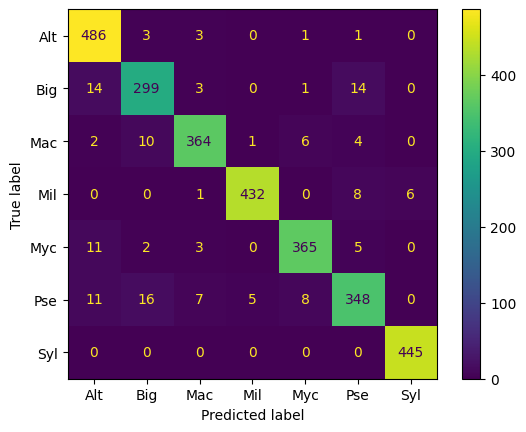

Accuracy : 0.9493934142114385
Balanced Accuracy : 0.9458212674969332


In [18]:
y_pred=all_outputs['ResNet50_ResNet50']['pred']
#y_obs=real_labels
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
#y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))

## MC DROPOUT